<a href="https://colab.research.google.com/github/jungeun202/Transformer/blob/main/LUNA/luna_translation_dataset2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using a luna transformer model with the translation dataset.

In [1]:
import torch
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
text_file = "/content/drive/MyDrive/spa.txt"

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv(text_file, names=['en', 'fr', 'attr'], usecols=['en', 'fr'], sep='\t')
df = df.sample(frac=1, random_state=42)
df = df.reset_index(drop=True)
df = df.iloc[:9000] # take the first 11000 rows
df.head()

,en,fr
0,Do you remember the day when we met each other...,¿Recuerdas el día en que nos encontramos por p...
1,It would be good if you ate it.,Sería bueno que lo comierais.
2,Tom doesn't like women who wear way too much m...,A Tom no le gustan las mujeres que usan demasi...
3,Our water heater is leaking.,Nuestro calentador pierde agua.
4,Don't be irresponsible.,No seas irresponsable.


In [5]:
import re
from unicodedata import normalize

def clean_text(text):
    # text = normalize('NFD', text.lower())
    text = re.sub('[^A-Za-z ]+', '', text) # Stripped of any characters that are not alphabets or spaces
    return text

def clean_and_prepare_text(text):
    text = normalize('NFD', text.lower()) # Normalized ; NFD (Normalization Form D) decomposes characters into their base characters and diacritical marks (accents)
    text = text.lower()
    text = '[start] ' + clean_text(text) + ' [end]' # French text is wrapped with special tokens
    return text

df['en'] = df['en'].apply(lambda row: clean_text(row))
df['fr'] = df['fr'].apply(lambda row: clean_and_prepare_text(row))
df.head()

,en,fr
0,Do you remember the day when we met each other...,[start] recuerdas el dia en que nos encontramo...
1,It would be good if you ate it,[start] seria bueno que lo comierais [end]
2,Tom doesnt like women who wear way too much ma...,[start] a tom no le gustan las mujeres que usa...
3,Our water heater is leaking,[start] nuestro calentador pierde agua [end]
4,Dont be irresponsible,[start] no seas irresponsable [end]


In [6]:
en = df['en']
fr = df['fr']
# get the maximum number of words in any phrase.
en_max_len = max(len(line.split()) for line in en)
fr_max_len = max(len(line.split()) for line in fr)
sequence_len = max(en_max_len, fr_max_len) # the length of the longest sequence in the dataset, whether in English or French

print(f'Max phrase length (English): {en_max_len}')
print(f'Max phrase length (French): {fr_max_len}')
print(f'Sequence length: {sequence_len}')

Max phrase length (English): 26
Max phrase length (French): 30
Sequence length: 30


In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# converted into numerical sequences and padded to a uniform length

en_tokenizer = Tokenizer()
en_tokenizer.fit_on_texts(en)
en_sequences = en_tokenizer.texts_to_sequences(en)
en_x = pad_sequences(en_sequences, maxlen=sequence_len, padding='post')

fr_tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@\\^_`{|}~\t\n')
fr_tokenizer.fit_on_texts(fr)
fr_sequences = fr_tokenizer.texts_to_sequences(fr)
fr_y = pad_sequences(fr_sequences, maxlen=sequence_len + 1, padding='post') # extra length accounts for the [start] and [end] tokens

In [8]:
en_vocab_size = len(en_tokenizer.word_index) + 1
fr_vocab_size = len(fr_tokenizer.word_index) + 1

print(f'Vocabulary size (English): {en_vocab_size}')
print(f'Vocabulary size (French): {fr_vocab_size}')

Vocabulary size (English): 4778
Vocabulary size (French): 7140


In [9]:
inputs = torch.tensor(en_x, dtype=torch.long)
outputs = torch.tensor(fr_y[:, 1:], dtype=torch.long) # remove the first column which contains [start] token; in the sequence to sequence model, we are predicting what words comes after [start] tokens.

In [10]:
# print(inputs)
print(inputs.size(0))

9000


In [11]:
print(inputs.size())

torch.Size([9000, 30])


In [10]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
from typing import Optional, Tuple
from torch import Tensor

class Embeddings(nn.Module):
  # Maps input tokens (words or characters) to dense vector representations (embeddings)
    def __init__(self, vocab_num, d_model):
        super(Embeddings, self).__init__()
        self.emb = nn.Embedding(vocab_num, d_model) # Initializes an embedding layer
        self.d_model = d_model

    def forward(self, x):
        return self.emb(x) * math.sqrt(self.d_model)

class PositionalEncoding(nn.Module):
  # Adds information about the position of each word in the sequence, allowing the model to distinguish between different positions.
    def __init__(self, d_model: int = 80, max_length: int = 5000) -> None:
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_length, d_model, requires_grad=False)
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, length: int) -> Tensor:
        return self.pe[:, :length]

class DotProductAttention(nn.Module):
    def __init__(self, dim: int, scale: bool = True) -> None:
        super(DotProductAttention, self).__init__()
        self.sqrt_dim = np.sqrt(dim) if scale else 1

    def forward(self, query: torch.FloatTensor, key: torch.FloatTensor, value: torch.FloatTensor, mask: Optional[torch.FloatTensor] = None) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        score = torch.matmul(query, key.transpose(2, 3)) / self.sqrt_dim
        # Calculates the attention scores by taking the dot product of the query and key vectors and scaling by the square root of the dimensionality.
        if mask is not None:
            score.masked_fill_(mask, -1e4)
        attn = F.softmax(score, -1)
        context = torch.bmm(attn, value) if len(query.size()) == 3 else torch.matmul(attn, value)
        return context, attn

class MultiHeadAttention(nn.Module):
    def __init__(self, dim: int = 512, num_attention_heads: int = 8) -> None:
        super(MultiHeadAttention, self).__init__()
        assert dim % num_attention_heads == 0, "hidden_dim % num_attention_heads should be zero."
        self.d_head = int(dim / num_attention_heads)
        self.num_attention_heads = num_attention_heads
        self.query_proj = nn.Linear(dim, self.d_head * num_attention_heads)
        self.key_proj = nn.Linear(dim, self.d_head * num_attention_heads)
        self.value_proj = nn.Linear(dim, self.d_head * num_attention_heads)
        self.scaled_dot_attn = DotProductAttention(dim, scale=True)

    def forward(self, query: torch.FloatTensor, key: torch.FloatTensor, value: torch.FloatTensor, mask: Optional[torch.FloatTensor] = None) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        batch_size = value.size(0)
        query = self.query_proj(query).view(batch_size, -1, self.num_attention_heads, self.d_head).transpose(1, 2)
        key = self.key_proj(key).view(batch_size, -1, self.num_attention_heads, self.d_head).transpose(1, 2)
        value = self.value_proj(value).view(batch_size, -1, self.num_attention_heads, self.d_head).transpose(1, 2)
        if mask is not None:
            mask = mask.unsqueeze(1).repeat(1, self.num_attention_heads, 1, 1)
        context, attn = self.scaled_dot_attn(query, key, value, mask)
        context = context.transpose(1, 2).reshape(batch_size, -1, self.num_attention_heads * self.d_head)
        return context, attn

class LinearUnifiedNestedAttention(nn.Module):
  # Encapsulates a "nested" attention mechanism with two multi-head attention layers: one for "packing" and one for "unpacking"
    def __init__(self, dim, num_attention_heads: int = 8) -> None:
        super(LinearUnifiedNestedAttention, self).__init__()
        self.pack_attention = MultiHeadAttention(dim, num_attention_heads) # proces key and value with a separate query tensor p
        self.unpack_attention = MultiHeadAttention(dim, num_attention_heads) # process the original query with the packed context.

    def forward(self, query: torch.FloatTensor, key: torch.FloatTensor, value: torch.FloatTensor, p: torch.FloatTensor, attention_padding_mask: torch.BoolTensor = None) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        packed_context, pack_attn = self.pack_attention(p, key, value, attention_padding_mask)
        unpacked_context, unpack_attn = self.unpack_attention(query, packed_context, packed_context)
        return unpacked_context, packed_context, pack_attn, unpack_attn

class PositionwiseFeedForwardNetwork(nn.Module):
    def __init__(self, d_model: int = 512, d_ff: int = 2048, dropout_p: float = 0.1) -> None:
        super(PositionwiseFeedForwardNetwork, self).__init__()
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.Dropout(dropout_p),
            nn.ReLU(),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout_p),
        )

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return self.feed_forward(inputs)

class LunaTransformerEncoderLayer(nn.Module):
    def __init__(self, d_model: int = 512, num_attention_heads: int = 8, d_ff: int = 2048, dropout_p: float = 0.1) -> None:
        super(LunaTransformerEncoderLayer, self).__init__()
        self.luna_attention = LinearUnifiedNestedAttention(d_model, num_attention_heads)
        self.feed_forward = PositionwiseFeedForwardNetwork(d_model, d_ff, dropout_p)
        self.packed_context_layer_norm = nn.LayerNorm(d_model)
        self.unpacked_context_layer_norm = nn.LayerNorm(d_model)
        self.feed_forward_layer_norm = nn.LayerNorm(d_model)

    def forward(self, inputs: torch.FloatTensor, p: torch.FloatTensor, attention_padding_mask: torch.FloatTensor = None):
        unpacked_context, packed_context, pack_attn, unpack_attn = self.luna_attention(query=inputs, key=inputs, value=inputs, p=p, attention_padding_mask=attention_padding_mask)
        packed_context = self.packed_context_layer_norm(packed_context + p)
        unpacked_context = self.unpacked_context_layer_norm(unpacked_context + inputs)
        outputs = self.feed_forward(unpacked_context)
        outputs = self.feed_forward_layer_norm(outputs + unpacked_context)
        return outputs, packed_context, pack_attn, unpack_attn

def get_attn_pad_mask(inputs, input_lengths, expand_length):
    def get_transformer_non_pad_mask(inputs: Tensor, input_lengths: Tensor) -> Tensor:
        batch_size = inputs.size(0)
        non_pad_mask = inputs.new_ones(inputs.size()[:-1] if len(inputs.size()) == 3 else inputs.size())
        for i in range(batch_size):
            non_pad_mask[i, int(input_lengths[i]):] = 0
        return non_pad_mask

    non_pad_mask = get_transformer_non_pad_mask(inputs, input_lengths)
    pad_mask = non_pad_mask.lt(1)
    attn_pad_mask = pad_mask.unsqueeze(1).expand(-1, expand_length, -1)
    return attn_pad_mask

def get_attn_subsequent_mask(seq):
    assert seq.dim() == 2
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1)
    return subsequent_mask.cuda() if seq.is_cuda else subsequent_mask

def calculate_project_embedding_length(input_length: int, base:float=2) -> int:
  return (max(1, int(math.log(input_length, base))))


# def calculate_project_embedding_length(input_length: int, chunk_size:int=50) -> int:
#   return max(1,input_length//chunk_size)

class LunaTransformerEncoder(nn.Module):
    # def __init__(self, vocab_size: int, d_model: int, depth: int, num_attention_heads: int = 8, d_ff: int = 2048, dropout_p: float = 0.1, sequence_len: int = 100, max_length: int = 1024):
    #     super(LunaTransformerEncoder, self).__init__()
    #     self.d_model = d_model
    #     self.projected_embedding_length = calculate_project_embedding_length(sequence_len)
    #     self.projected_embeddings = nn.Parameter(torch.Tensor(self.projected_embedding_length, self.d_model))
    #     self.projected_positions = PositionalEncoding(self.d_model, self.projected_embedding_length)
    #     nn.init.normal_(self.projected_embeddings, mean=0.0, std=self.d_model ** -0.5)
    #     self.input_embedding = nn.Embedding(vocab_size, d_model)
    #     self.dropout = nn.Dropout(p=dropout_p)
    #     self.input_positions = PositionalEncoding(d_model, max_length)
    #     self.input_norm = nn.LayerNorm(d_model)
    #     self.embed_scale = math.sqrt(self.d_model)
    #     self.layers = nn.ModuleList([
    #         LunaTransformerEncoderLayer(d_model=d_model, num_attention_heads=num_attention_heads, d_ff=d_ff, dropout_p=dropout_p) for _ in range(depth)
    #     ])
    #     self.projection_head = nn.Linear(d_model, vocab_size)
    #     self.attn_weights = []  # to store attention weights
    def __init__(self, vocab_size: int, d_model: int, num_layers: int = 6, num_attention_heads: int = 8, d_ff: int = 2048, dropout_p: float = 0.1, project_embedding_length: int = 5, max_length: int = 1024):
        super(LunaTransformerEncoder, self).__init__()
        self.d_model = d_model
        self.projected_embedding_length = project_embedding_length
        self.projected_embeddings = nn.Parameter(torch.Tensor(project_embedding_length, self.d_model))
        self.projected_positions = PositionalEncoding(self.d_model, project_embedding_length)
        nn.init.normal_(self.projected_embeddings, mean=0.0, std=self.d_model ** -0.5)
        self.input_embedding = nn.Embedding(vocab_size, d_model)
        self.dropout = nn.Dropout(p=dropout_p)
        self.input_positions = PositionalEncoding(d_model, max_length)
        self.input_norm = nn.LayerNorm(d_model)
        self.embed_scale = math.sqrt(self.d_model)
        self.layers = nn.ModuleList([
            LunaTransformerEncoderLayer(d_model=d_model, num_attention_heads=num_attention_heads, d_ff=d_ff, dropout_p=dropout_p) for _ in range(num_layers)
        ])
        self.projection_head = nn.Linear(d_model, vocab_size)

    # def forward(self, inputs: torch.Tensor, input_lengths: torch.Tensor):
    #     batch_size, seq_length = inputs.size()
    #     attention_padding_mask = get_attn_pad_mask(inputs, input_lengths, self.projected_embedding_length)
    #     embedded = self.input_embedding(inputs) * self.embed_scale
    #     projected_embedded = self.projected_embeddings * self.embed_scale
    #     embedded += self.input_positions(embedded.size(1))
    #     projected_embedded += self.projected_positions(self.projected_embedding_length).squeeze(0)
    #     seq_length, dim = projected_embedded.size()
    #     projected_embedded = projected_embedded.unsqueeze(0).expand(batch_size, seq_length, dim)
    #     outputs = self.dropout(embedded)
    #     p = self.dropout(projected_embedded)
    #     for layer in self.layers:
    #         outputs, p = layer(outputs, p, attention_padding_mask)
    #     outputs = self.input_norm(outputs)
    #     outputs = self.projection_head(outputs)
    #     return outputs

    def update_projected_embeddings(self, sequence_len):
        # Recalculate projected embedding length
        self.projected_embedding_length = calculate_project_embedding_length(sequence_len)
        # Update projected embeddings and positional encodings
        self.projected_embeddings = nn.Parameter(torch.Tensor(self.projected_embedding_length, self.d_model).to(self.projected_embeddings.device))
        nn.init.normal_(self.projected_embeddings, mean=0.0, std=self.d_model ** -0.5)
        self.projected_positions = PositionalEncoding(self.d_model, self.projected_embedding_length).to(self.projected_embeddings.device)
        print("projected_embedding_length: ", self.projected_embedding_length)

    def forward(self, inputs: torch.Tensor, input_lengths: torch.Tensor):
        batch_size, seq_length = inputs.size()

        attention_padding_mask = get_attn_pad_mask(inputs, input_lengths, self.projected_embedding_length)
        embedded = self.input_embedding(inputs) * self.embed_scale
        projected_embedded = self.projected_embeddings * self.embed_scale
        embedded += self.input_positions(embedded.size(1))
        projected_embedded += self.projected_positions(self.projected_embedding_length).squeeze(0)
        seq_length, dim = projected_embedded.size()
        projected_embedded = projected_embedded.unsqueeze(0).expand(batch_size, seq_length, dim)
        outputs = self.dropout(embedded)
        p = self.dropout(projected_embedded)
        self.attn_weights = []  # Reset the attention weights for each forward pass
        for layer in self.layers:
            outputs, p, pack_attn, unpack_attn = layer(outputs, p, attention_padding_mask)
            self.attn_weights.append((pack_attn, unpack_attn))
        outputs = self.input_norm(outputs)
        outputs = self.projection_head(outputs)
        # print("project_embedding_length: ", self.projected_embedding_length)
        return outputs


In [11]:
import torch.optim as optim
import torch
import time
import numpy as np
from torch.nn.utils import clip_grad_norm_
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_
import time

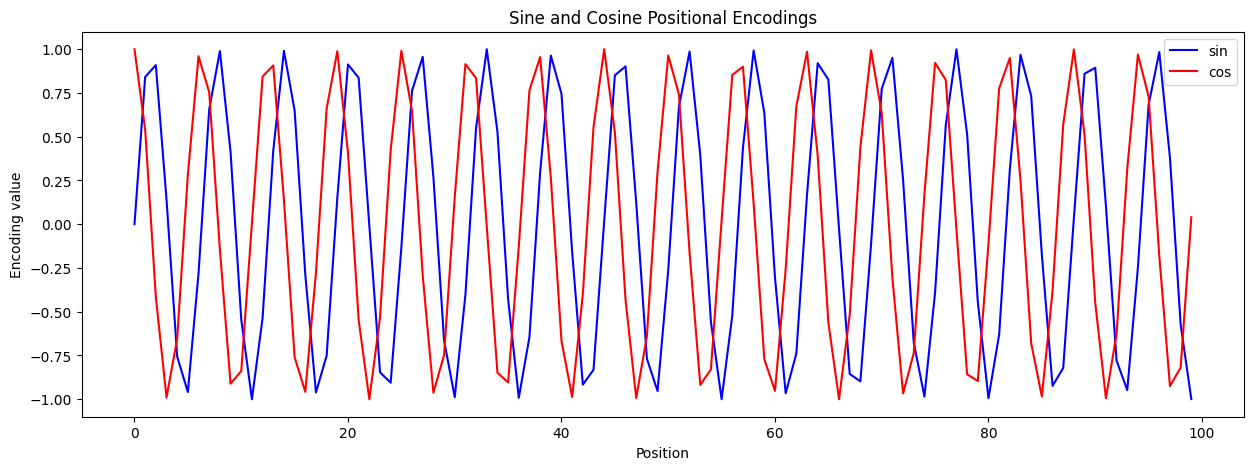

In [15]:
import matplotlib.pyplot as plt

def plot_positional_encodings(d_model, max_len):
    pos_enc = PositionalEncoding(d_model, max_len).forward(max_len).squeeze(0).cpu().numpy()
    plt.figure(figsize=(15, 5))
    plt.plot(pos_enc[:, 0], label='sin', color='blue')
    plt.plot(pos_enc[:, 1], label='cos', color='red')
    plt.legend()
    plt.title('Sine and Cosine Positional Encodings')
    plt.xlabel('Position')
    plt.ylabel('Encoding value')
    plt.show()

plot_positional_encodings(d_model=512, max_len=100)


EXPERIMENTS

In [12]:
epoch_losses = []
losses = []
times = []
gradient_norms = []

In [13]:
# the default depth is 6
# Training parameters and model setup
dim = 512
depth = 6
num_epochs = 10
batch_size = 32
learning_rate = 0.0001
head_num = 8
sequence_lengths = [100, 200, 300, 400, 500]  # Different sequence lengths to test
vocab_size = max(en_vocab_size, fr_vocab_size)  # Adjust to use the correct vocabulary size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = LunaTransformerEncoder(vocab_size, dim, depth, head_num, max_seq_len, dropout_p=0.1).to(device)
model = LunaTransformerEncoder(vocab_size, dim, depth, head_num, max(sequence_lengths), dropout_p=0.1).to(device)
# model = LunaTransformerEncoder(vocab_size, dim, depth, head_num, 300, dropout_p=0.1).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for max_seq_len in sequence_lengths:
    num_batches = inputs.size(0) // batch_size # the number of samples that will be propagated through the network.--> 30
    # inputs.size(0) : total number of sequences (samples) in the adjusted dataset for the current sequence length --> 10000
    print(f"Training with sequence length: {max_seq_len}")

    # Dynamically update the projected embedding length
    model.update_projected_embeddings(max_seq_len)

    print(f"num_batches: ", num_batches)
    # if num_batches == 0:
    #     print(f"Skipping sequence length {max_seq_len} due to insufficient data size.")
    #     continue


    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for i in range(0, inputs.size(0), batch_size):
            input_batch = inputs[i:i+batch_size].to(device)
            target_batch = outputs[i:i+batch_size].to(device)
            input_lengths = torch.tensor([seq.ne(0).sum().item() for seq in input_batch], dtype = torch.int32, device = device) # compuets the number of nonzero tokens (non-padding tokens) in each sequence of the batch

            # print(f"Input Lengths: {input_lengths.tolist()}")

            # optimizer.zero_grad()
            output_batch = model(input_batch, input_lengths)
            output_flat = output_batch.view(-1, vocab_size)
            target_flat = target_batch.view(-1)

            loss = criterion(output_flat, target_flat)
            optimizer.zero_grad()

            loss.backward()
            # Calculate gradient norm
            total_norm = 0
            for param in model.parameters():
                if param.grad is not None:
                    param_norm = param.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
            gradient_norms.append(total_norm)

            clip_grad_norm_(model.parameters(), 0.5)

            optimizer.step()

            total_loss += loss.item()

        epoch_losses.append(total_loss/num_batches)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/num_batches:.4f}')
    elapsed_time = time.time() - start_time
    avg_loss = total_loss / (num_batches * num_epochs)
    losses.append(avg_loss)
    times.append(elapsed_time)



Training with sequence length: 100
projected_embedding_length:  6
num_batches:  281
Epoch [1/10], Loss: 1.6229
Epoch [2/10], Loss: 1.3178
Epoch [3/10], Loss: 1.2175
Epoch [4/10], Loss: 1.1365
Epoch [5/10], Loss: 1.0675
Epoch [6/10], Loss: 1.0081
Epoch [7/10], Loss: 0.9538
Epoch [8/10], Loss: 0.9026
Epoch [9/10], Loss: 0.8525
Epoch [10/10], Loss: 0.8024
Training with sequence length: 200
projected_embedding_length:  7
num_batches:  281
Epoch [1/10], Loss: 0.7566
Epoch [2/10], Loss: 0.7065
Epoch [3/10], Loss: 0.6601
Epoch [4/10], Loss: 0.6138
Epoch [5/10], Loss: 0.5756
Epoch [6/10], Loss: 0.5369
Epoch [7/10], Loss: 0.4985
Epoch [8/10], Loss: 0.4684
Epoch [9/10], Loss: 0.4391
Epoch [10/10], Loss: 0.4132
Training with sequence length: 300
projected_embedding_length:  8
num_batches:  281
Epoch [1/10], Loss: 0.3916
Epoch [2/10], Loss: 0.3654
Epoch [3/10], Loss: 0.3442
Epoch [4/10], Loss: 0.3295
Epoch [5/10], Loss: 0.3115
Epoch [6/10], Loss: 0.2957
Epoch [7/10], Loss: 0.2844
Epoch [8/10], Los

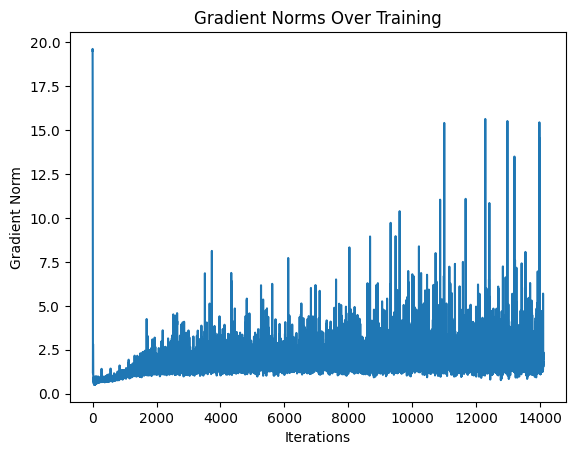

In [14]:
plt.plot(gradient_norms)
plt.title('Gradient Norms Over Training')
plt.xlabel('Iterations')
plt.ylabel('Gradient Norm')
plt.show()


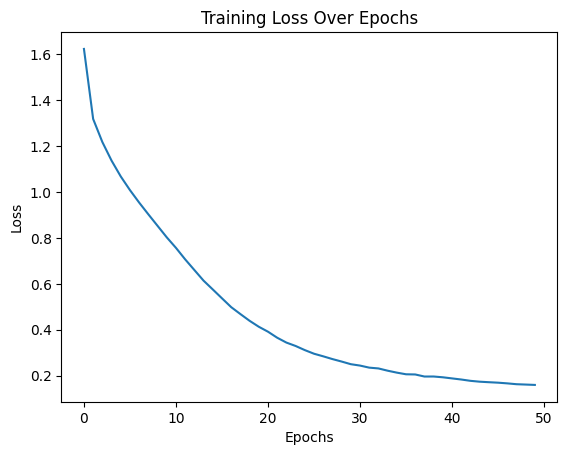

In [15]:
plt.plot(epoch_losses)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


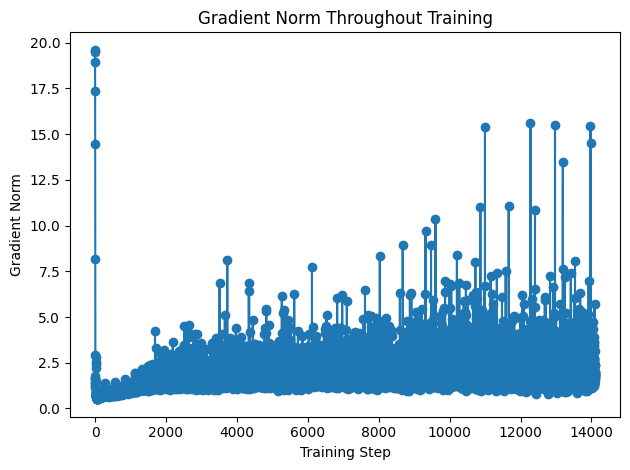

In [19]:
plt.plot(range(len(gradient_norms)), gradient_norms, marker='o')
plt.xlabel('Training Step')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norm Throughout Training')

plt.tight_layout()
plt.show()

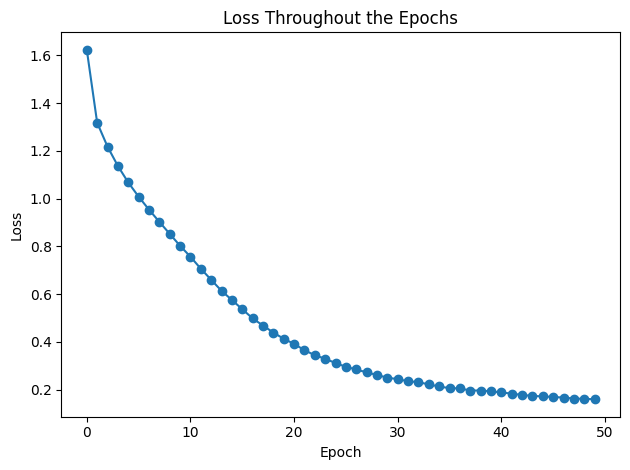

In [18]:
plt.plot(range(len(epoch_losses)), epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Throughout the Epochs')

plt.tight_layout()
plt.show()